In [37]:
!pip install shap


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
import shap

### Random Forest Classification for Sentiment Categories

To predict stock sentiment categories (**Bullish**, **Bearish**, **Neutral**) from post-earnings indicators, a **Random Forest classifier** is trained using features such as **Earnings_Surprise**, **Firm_Size**, and **method_2** sentiment scores. The model is trained on pre-2024 data and evaluated on 2024 data. Classification performance is assessed using **accuracy** and a **detailed classification report** that includes precision, recall, and F1-score for each sentiment class.


In [38]:

# Load the training and test datasets
train_df = pd.read_csv("training_data.csv")
test_df = pd.read_csv("test_data.csv")

# Define feature columns and target column
feature_columns = ["Earnings_Surprise", "Firm_Size", "method_2"]
target_column = "Category"

X_train = train_df[feature_columns]
y_train = train_df[target_column]

X_test = test_df[feature_columns]
y_test = test_df[target_column]

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9743
Classification Report:
              precision    recall  f1-score   support

     Bearish       0.97      0.99      0.98       733
     Bullish       0.99      0.98      0.99       448
     Neutral       0.96      0.83      0.89       103

    accuracy                           0.97      1284
   macro avg       0.97      0.94      0.95      1284
weighted avg       0.97      0.97      0.97      1284



### Feature Importance in Random Forest Classification

To understand the influence of each feature on the model's predictions, feature importances are extracted from the trained **Random Forest classifier**. A horizontal bar chart visualizes the relative importance of **Earnings_Surprise**, **Firm_Size**, and **method_2**, offering insights into which variables most strongly drive the classification of post-earnings sentiment categories.


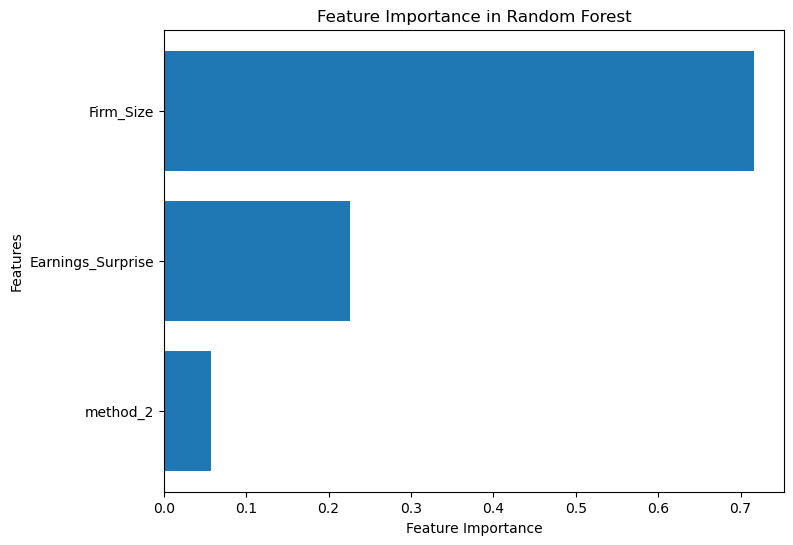

In [39]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_columns)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()

### Decision Tree Visualization from Random Forest

To enhance interpretability, a single decision tree from the trained **Random Forest model** is visualized. The plot displays decision rules based on **Earnings_Surprise**, **Firm_Size**, and **method_2**, showing how the model classifies stocks into **Bullish**, **Bearish**, or **Neutral** categories. This visualization provides a transparent view into the logic behind individual tree decisions.


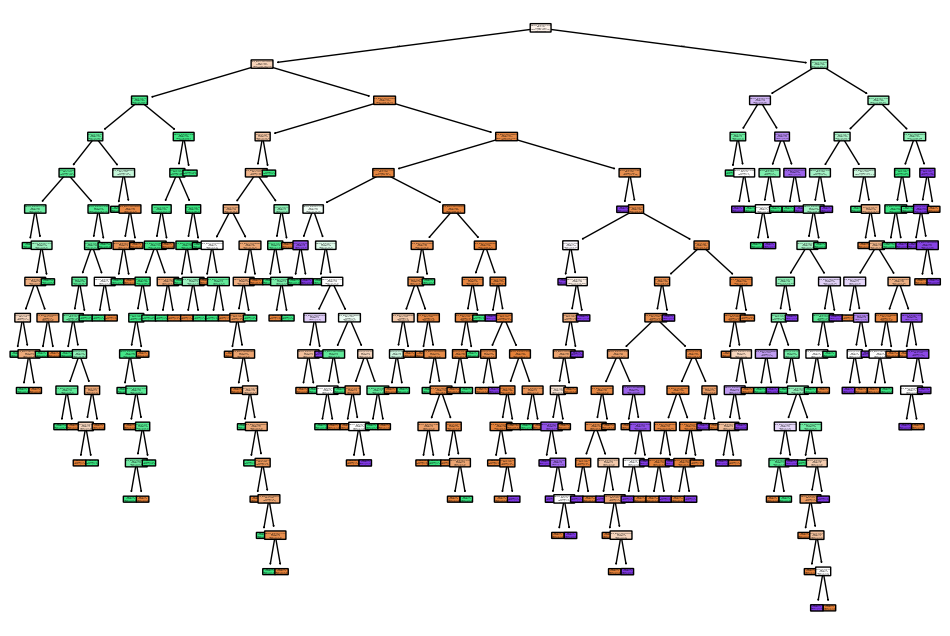

In [40]:

# Select a single tree from the Random Forest
tree = rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=feature_columns, class_names=rf_model.classes_, filled=True, rounded=True)
plt.show()


### SHAP Value Computation for Model Explainability

To interpret how each feature influences the Random Forest model’s predictions, **SHAP (SHapley Additive exPlanations)** values are computed using the test set. A SHAP explainer is initialized on the trained model and applied to the test data to generate local explanations for each prediction. These values quantify the contribution of each feature toward the final classification, offering a transparent and model-agnostic way to explain prediction behavior.


In [41]:

# Create SHAP explainer
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)

print(type(shap_values))
print(shap_values)



 99%|===================| 3821/3852 [00:18<00:00]        

<class 'shap._explanation.Explanation'>
.values =
array([[[-0.1615    ,  0.11443333,  0.04706667],
        [ 0.2223    , -0.09511666, -0.12718333],
        [-0.0034    ,  0.00718333, -0.00378333]],

       [[ 0.1382    , -0.01468333, -0.12351666],
        [ 0.34424999, -0.35508333,  0.01083333],
        [-0.01505   , -0.00373333,  0.01878333]],

       [[ 0.18095   , -0.03936667, -0.14158333],
        [ 0.25204999, -0.33736666,  0.08531667],
        [ 0.0344    ,  0.00323333, -0.03763333]],

       ...,

       [[ 0.15585   , -0.03525   , -0.1206    ],
        [ 0.30739999, -0.33574999,  0.02835   ],
        [ 0.01415   , -0.0025    , -0.01165   ]],

       [[ 0.07471667, -0.03023333, -0.04448333],
        [-0.60678332,  0.65861665, -0.05183333],
        [ 0.00946667, -0.00188333, -0.00758333]],

       [[-0.57853332,  0.11683333,  0.46169999],
        [ 0.07391667, -0.45956666,  0.38564999],
        [ 0.00201667, -0.00076667, -0.00125   ]]])

.base_values =
array([[0.5226, 0.3735, 0.1

In [42]:
import joblib

# Save the model to a file
joblib.dump(rf_model, "random_forest_model.pkl")

print("Model saved successfully!")


Model saved successfully!
